In [2]:
import xarray as xr
import wrf
from netCDF4 import Dataset
import numpy as np
import glob
import hvplot.xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import tqdm
import pyart
import datetime as dt


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


0.3.0


In [3]:
#Load WRF output files
wrflist = [Dataset(f) for f in np.sort(glob.glob("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead/wrfout_d04_2023-10-*"))]
wrflist_highres = [Dataset(f) for f in np.sort(glob.glob("/g/data/w40/ab4502/WRF_simulations/tasman_d04_20231015_20231016_ramssa_shortlead/highres_d04_2023-10-*"))]
times = wrf.extract_times(wrflist,wrf.ALL_TIMES)
times_highres = wrf.extract_times(wrflist_highres,wrf.ALL_TIMES)

In [4]:
#Look at available variables
wrflist[0].variables.keys()

dict_keys(['Times', 'XLAT', 'XLONG', 'ZNU', 'ZNW', 'U', 'V', 'W', 'PH', 'PHB', 'T', 'THM', 'P', 'PB', 'P_HYD', 'Q2', 'T2', 'TH2', 'PSFC', 'U10', 'V10', 'XTIME', 'QNDROP', 'QNRAIN', 'QNICE', 'QNSNOW', 'QNGRAUPEL', 'QNHAIL', 'QVGRAUPEL', 'QVHAIL', 'TSLB', 'SSTSK', 'TKE_PBL', 'HGT', 'TSK', 'T00', 'P00', 'TLP', 'TLP_STRAT', 'P_STRAT', 'RAINC', 'RAINSH', 'GRAUPELNC', 'HAILNC', 'CLDFRA', 'XLAT_U', 'XLONG_U', 'XLAT_V', 'XLONG_V', 'CLAT', 'UST', 'PBLH', 'QFX', 'SR', 'UP_HELI_MAX', 'W_MEAN', 'GRPL_MAX', 'HAIL_MAXK1', 'HAIL_MAX2D', 'ISNOW', 'QSNOWXY', 'QRAINXY', 'TCOLI_MAX', 'GRPL_FLX_MAX', 'AFWA_MSLP', 'AFWA_TOTPRECIP', 'AFWA_CIN', 'AFWA_ZLFC', 'AFWA_PLFC', 'AFWA_LIDX', 'AFWA_PWAT', 'AFWA_HAIL', 'AFWA_LLWS', 'AFWA_TORNADO', 'LANDMASK', 'LAKEMASK', 'SST', 'SST_INPUT'])

In [5]:
#Extract U10 and V10 variables, and calculate 10 m wind speed
u10 = wrf.getvar(wrflist_highres, "U10", timeidx=wrf.ALL_TIMES, method="cat")
v10 = wrf.getvar(wrflist_highres, "V10", timeidx=wrf.ALL_TIMES, method="cat")
ws = np.sqrt(np.square(u10) + np.square(v10))
#theta = wrf.getvar(wrflist, "theta", timeidx=wrf.ALL_TIMES, method="cat")

# #Extract max reflectivity (think that this is max since previous output interval, which isn't ideal)
# refd_max = np.concatenate([wrflist[t]["REFD_MAX"][:] for t in range(len(wrflist))],axis=0)

# #Extract 3d reflectivity (something is wrong with this output. For the first time step in the hourly files, it's fine, but the next 10-minute steps don't update aloft)
# refd_10cm_max = np.concatenate(([np.max(wrflist[t]["REFL_10CM"][:,:,:,:],axis=1) for t in tqdm.tqdm(range(len(wrflist)))]),axis=0)

In [6]:
#td = wrf.getvar(wrflist,"td",wrf.ALL_TIMES,units="degC")
#td10 = wrf.interplevel(td,wrf.getvar(wrflist,"z",wrf.ALL_TIMES),10)
td2 = wrf.getvar(wrflist,"td2",wrf.ALL_TIMES,units="degC")

In [7]:
#From the underway data directory, load navigation info
underway_data_path = "/g/data/w40/ab4502/IN2023_V06/data/underway/"
fnames = ["20231014-213337-shipnav-shipnav_01.nav","20231015-093337-shipnav-shipnav_01.nav","20231015-213338-shipnav-shipnav_01.nav"]
underway_nav = xr.open_mfdataset([underway_data_path+s for s in fnames])[["lat","long"]]

#Extract ship lat/lon at WRF output times
ship_lons = []
ship_lats = []
for t in tqdm.tqdm(range(ws.Time.shape[0])):
    current_nav = underway_nav.sel(time=ws.isel(Time=t).Time.values,method="nearest")
    ship_lat, ship_lon = current_nav.lat.values, current_nav.long.values
    ship_lats.append(float(ship_lat))
    ship_lons.append(float(ship_lon))

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/argopy/__init__.py:32: DeprecationWarning: The 'argopy.utilities' has moved to 'argopy.utils'. After 0.1.15, importing 'utilities' will raise an error. Please update your script.
  from . import utilities  # noqa: E402  # being deprecated until 0.1.15, then remove
100%|██████████| 127/127 [00:00<00:00, 297.56it/s]


In [8]:
#Create a series of wind gust plots for animation
!rm /g/data/w40/ab4502/IN2023_V06/figs/wind_gust_plots/*.png
for t in tqdm.tqdm(range(ws.Time.shape[0])):
    ax=plt.axes(projection=ccrs.PlateCarree())
    levels=10
    cmap=plt.get_cmap("Reds")
    c=xr.plot.contourf(ws.isel({"Time":t}),x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=np.linspace(0,30,levels),cmap=cmap,extend="max")
    
    plt.plot(ship_lons[0:t],ship_lats[0:t],color="tab:blue")
    plt.plot(ship_lons[t],ship_lats[t],marker="o",color="tab:blue")
    
    plt.savefig("/g/data/w40/ab4502/IN2023_V06/figs/wind_gust_plots/"+str(t).zfill(4)+".png",)
    plt.close()
    
#convert -delay 15 /g/data/w40/ab4502/IN2023_V06/figs/wind_gust_plots/*.png ~/working/Marine-SCW/animation.gif    

100%|██████████| 127/127 [00:33<00:00,  3.81it/s]


In [7]:
#Create a series of perturbation potential temperature plots for animation
!rm /g/data/w40/ab4502/IN2023_V06/figs/t_plots/*.png
for t in tqdm.tqdm(range(theta.Time.shape[0])):
    ax=plt.axes(projection=ccrs.PlateCarree())
    levels=11
    cmap=plt.get_cmap("Blues_r")
    c=xr.plot.contourf(theta.isel({"Time":t,"bottom_top":0}),x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),levels=np.linspace(282,293),ax=ax,cmap=cmap,extend="both")
    
    plt.plot(ship_lons[0:t],ship_lats[0:t],color="k")
    plt.plot(ship_lons[t],ship_lats[t],marker="o",color="k")
    
    plt.savefig("/g/data/w40/ab4502/IN2023_V06/figs/t_plots/"+str(t).zfill(4)+".png",)
    plt.close()
    
#convert -delay 15 /g/data/w40/ab4502/IN2023_V06/figs/t_plots/*.png ~/working/Marine-SCW/animation_t.gif    

100%|██████████| 73/73 [00:45<00:00,  1.61it/s]


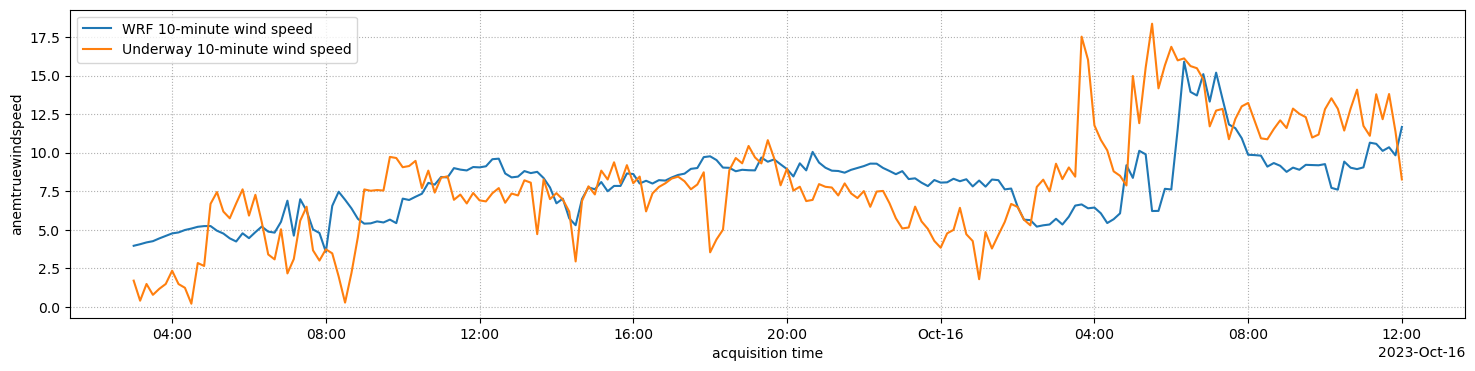

In [17]:
#Compare ship wind measurements with WRF wind field at the same points.

ship_x, ship_y = wrf.ll_to_xy(wrflist_highres,ship_lats,ship_lons).values
target_x = xr.DataArray(ship_x,dims="points")
target_y = xr.DataArray(ship_y,dims="points")
time_points = ws.sel(south_north=target_y, west_east=target_x).values

plt.figure(figsize=[18,4])
plt.plot(times_highres,[time_points[t,t] for t in range(time_points.shape[0])],label="WRF 10-minute wind speed")
plt.gca().grid(ls=":")


underway_data_path = "/g/data/w40/ab4502/IN2023_V06/data/underway/"

fnames = ["20231014-213339-weather-met_01.met","20231015-093340-weather-met_01.met","20231015-213339-weather-met_01.met","20231016-093341-weather-met_01.met"]
underway_weather = xr.open_mfdataset([underway_data_path+s for s in fnames])
(underway_weather["anemtruewindspeed"]/1.94384).sel(time=times_highres,method="nearest").plot(label="Underway 10-minute wind speed")
plt.legend()

100%|██████████| 34/34 [00:00<00:00, 267.61it/s]


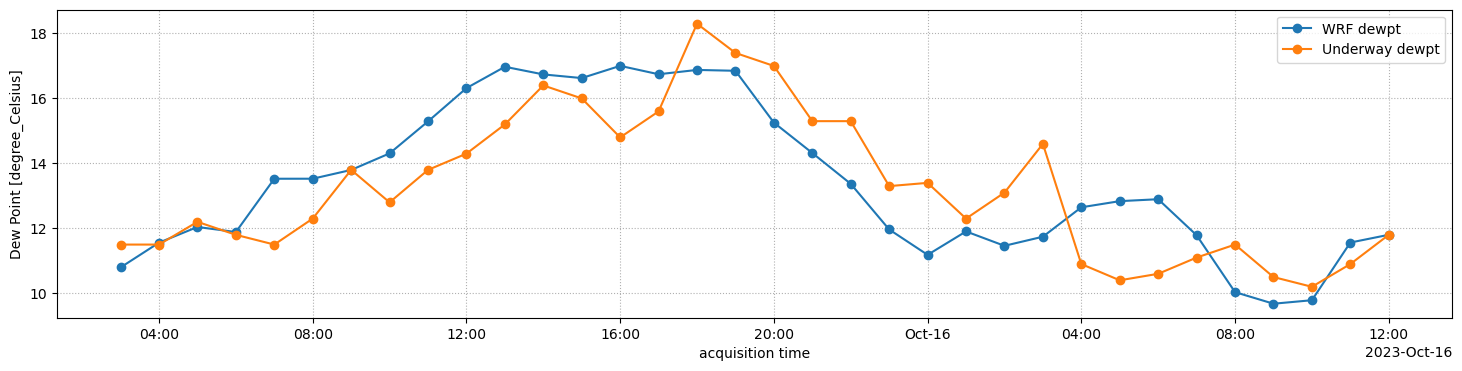

In [23]:
#Extract ship lat/lon at WRF output times
ship_lons = []
ship_lats = []
for t in tqdm.tqdm(range(td2.Time.shape[0])):
    current_nav = underway_nav.sel(time=ws.isel(Time=t).Time.values,method="nearest")
    ship_lat, ship_lon = current_nav.lat.values, current_nav.long.values
    ship_lats.append(float(ship_lat))
    ship_lons.append(float(ship_lon))
    
ship_x, ship_y = wrf.ll_to_xy(wrflist,ship_lats,ship_lons).values
target_x = xr.DataArray(ship_x,dims="points")
target_y = xr.DataArray(ship_y,dims="points")
time_points = td2.sel(south_north=target_y, west_east=target_x).values

plt.figure(figsize=[18,4])
plt.plot(times,[time_points[t,t] for t in range(time_points.shape[0])],marker="o",label="WRF dewpt")
plt.gca().grid(ls=":")

(underway_weather["dewpt"]).sel(time=times,method="nearest").plot(marker="o",label="Underway dewpt")
plt.legend()

Text(0.5, 1.0, 'Max obs reflectivity up to 6 km (2023-10-16 0400)')

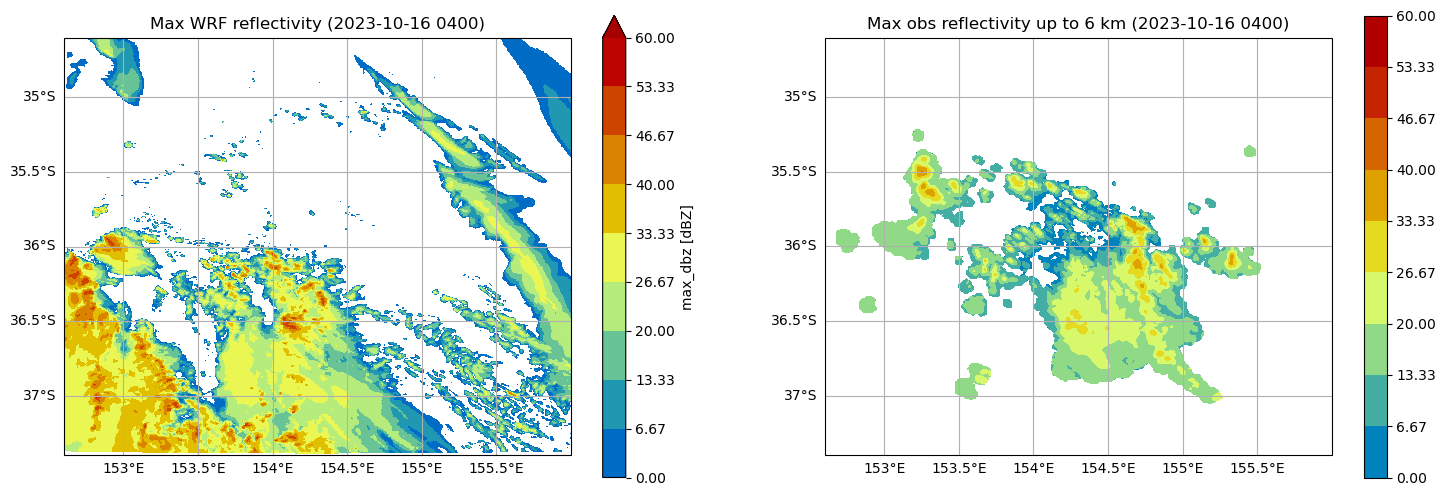

In [50]:
plt.figure(figsize=[18,6])

ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
levels=10
cmap=plt.get_cmap("Reds")
c=mdbz.plot(levels=np.linspace(0,60,10), cmap=pyart.graph.cm_colorblind.HomeyerRainbow, extend="max",ax=ax,x="XLONG",y="XLAT")
ax.gridlines(draw_labels=["bottom","left"])
ax.set_xlim([152.6,156])
ax.set_ylim([-37.4,-34.6])
plt.title("Max WRF reflectivity (2023-10-16 0400)")

ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
radar = xr.open_dataset("/g/data/w40/ab4502/IN2023_V06/data/radar/510/20231016/510_20231016_0400.nc")
plt.contourf(radar.longitude.values, radar.latitude.values,radar.dBZ_radar1.max("z").values,levels=np.linspace(0,60,10),cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
ax.gridlines(draw_labels=["bottom","left"])
plt.colorbar()
ax.set_xlim([152.6,156])
ax.set_ylim([-37.4,-34.6])
plt.title("Max obs reflectivity up to 6 km (2023-10-16 0400)")

In [28]:
mdbz = [wrf.getvar(wrflist,"mdbz",t) for t in tqdm.tqdm(np.arange(126,len(times),3))]

100%|██████████| 25/25 [16:11<00:00, 38.85s/it]


In [57]:
mbz_times = times[np.arange(126,len(times),3)]

#Create a series of wind gust plots for animation
!rm /g/data/w40/ab4502/IN2023_V06/figs/refd_max_plots/*.png
for t in tqdm.tqdm(range(len(mbz_times))):
    ax=plt.axes(projection=ccrs.PlateCarree())
    levels=10
    c=mdbz[t].plot(levels=np.linspace(0,60,10), cmap=pyart.graph.cm_colorblind.HomeyerRainbow, extend="max",ax=ax,x="XLONG",y="XLAT")
    
    plt.plot(ship_lons[0:np.arange(126,len(times),3)[t]],ship_lats[0:np.arange(126,len(times),3)[t]],color="k")
    plt.plot(ship_lons[np.arange(126,len(times),3)[t]],ship_lats[np.arange(126,len(times),3)[t]],marker="o",color="k")
    
    plt.savefig("/g/data/w40/ab4502/IN2023_V06/figs/refd_max_plots/"+str(t).zfill(4)+".png",)
    plt.close()
    
#convert -delay 15 /g/data/w40/ab4502/IN2023_V06/figs/refd_max_plots/*.png ~/working/Marine-SCW/animation_refd.gif    

100%|██████████| 25/25 [00:13<00:00,  1.86it/s]
